# Variational Autoencoders (VAE, 2013)

## Idea

**Main Idea**
- Variational Autoencoders (VAE) are generative models that create new data by learning hidden representations of input data.

**Pros**

- **Data Generation:** Ability to generate new data similar to training data
- **Interpolation:** Smooth transitions between different types of data
- **Robustness:** Resistance to overfitting due to variational inference
- **Complex Data Exploration:** Capability to analyze and visualize complex data distributions

**Cons**

1. **Sample Quality:** Lower clarity of generated data compared to GANs.
2. **Setup Complexity:** Challenges in balancing reconstruction quality and distribution.
3. **Sensitivity to Priors:** Performance impact based on the choice of prior distribution.
4. **Expressiveness:** Limitations due to using normal distributions for latent variables.

## AE

![https://towardsdatascience.com/difference-between-autoencoder-ae-and-variational-autoencoder-vae-ed7be1c038f2](content/img2001_AE.png "AE")

$$
\Huge \text{loss} = \text{MSE} = \| x - \hat{x} \|_2 = \| x - d_\phi(z) \|_2 = \| x - d_\phi(e_\theta(x)) \|_2
$$

### Simple AE

![https://proproprogs.ru/neural_network/avtoenkodery-chto-eto-kak-rabotayut](content/img2004_AESimple.png "AESimple")

In this scheme, the encoder performs a very simple operation: \
$\large h_1 = w_{11} \cdot x_1 + w_{12} \cdot x_2 $

And the decoder unfolds the value $ h $ back into a two-dimensional vector: \
$ \large
\begin{bmatrix}
y_1 \\
y_2
\end{bmatrix} = 
\begin{bmatrix}
w_{21} \\
w_{22}
\end{bmatrix} \cdot h_1
$

Assuming that the value $ h $ is just the sum of the inputs: \
$ \large h_1 = x_1 + x_2, \quad w_{11} = w_{12} = 1 $


Then, the decoder tries to restore these two values and does it, for example, in the following way: \
$ \large
\begin{bmatrix}
y_1 \\
y_2
\end{bmatrix} = 
\begin{bmatrix}
0.5 \\
0.5
\end{bmatrix} \cdot h_1, \quad w_{21} = w_{22} = 0.5
$

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


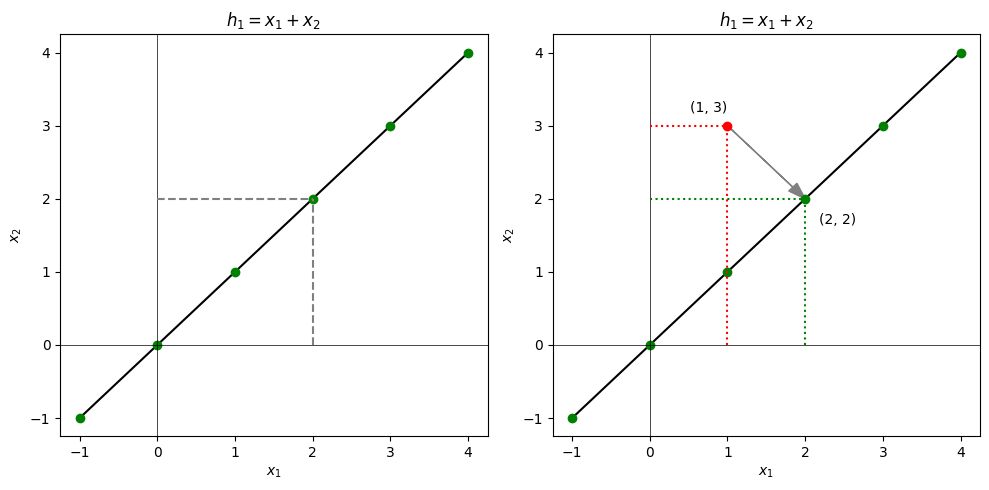

In [85]:
%load_ext autoreload
%autoreload 2
from utils import simple_ae_plot

simple_ae_plot()

The hidden state vector describes a certain model of data representation, \
and the more accurately this model describes the input values, the better the decoder can reconstruct them

### Data Loading

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input

size: 60000, 10000
labels: 0 - 9
values: 0 - 255


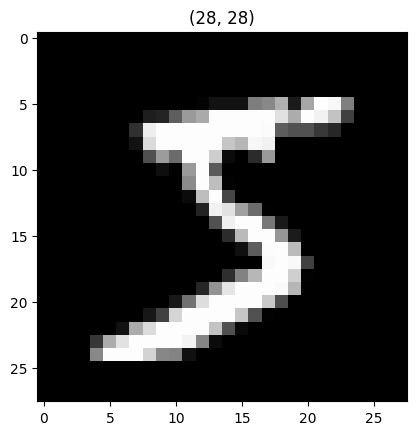

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"size: {x_train.shape[0]}, {x_test.shape[0]}")
print(f"labels: {y_train.min()} - {y_train.max()}")
print(f"values: {x_train[0].min()} - {x_train[0].max()}")

plt.title(x_train[0].shape)
plt.imshow(x_train[0], cmap='gray')
plt.show()

In [3]:
# data normalization
x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

### Implementation

In [5]:
input_img = Input(shape=(28, 28, 1))
x = Flatten()(input_img)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
encoded = Dense(2, activation='linear')(x)

input_enc = Input(shape=(2,))
d = Dense(64, activation='relu')(input_enc)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)

encoder = keras.Model(input_img, encoded, name="encoder")
decoder = keras.Model(input_enc, decoded, name="decoder")
autoencoder = keras.Model(input_img, decoder(encoder(input_img)), name="autoencoder")
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

2024-04-17 15:30:44.941970: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Fit

In [6]:
%%time

autoencoder.fit(
    x_train,
    x_train,
    epochs=10,
    batch_size=64,
    shuffle=True
)

Epoch 1/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0605
Epoch 2/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0496
Epoch 3/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0475
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0463
Epoch 5/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0454
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0446
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0441
Epoch 8/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0436
Epoch 9/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0432
Epoch 10/10
938/938 [==============================] - 6s 7ms/step - loss: 0.0429
CPU times: user 1min 43s, sys: 11.9 s, total: 1min 55s
Wall time: 1min 1s


### Analisys

In [7]:
h = encoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


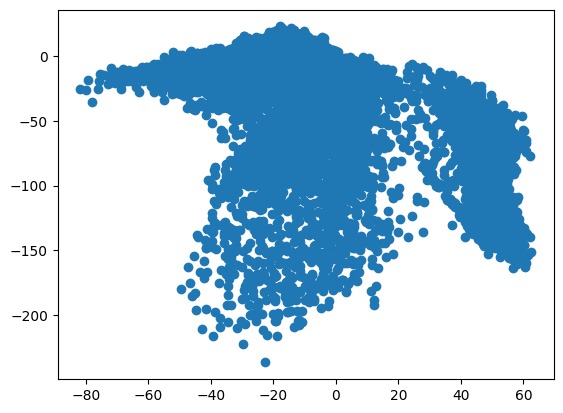

In [8]:
# distribution of hidden state vector points for a test set of images
plt.scatter(h[:, 0], h[:, 1])
plt.show()

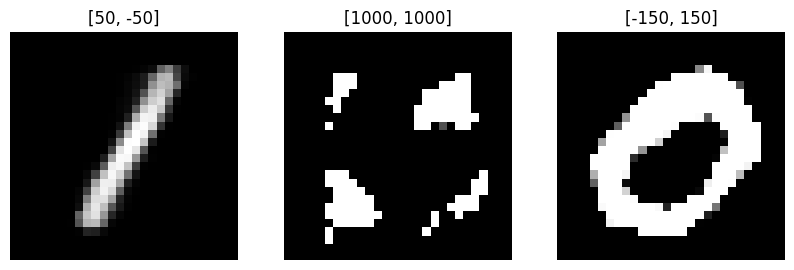

In [11]:
coordinates = [[50, -50], [1000, 1000], [-150, 150]]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i, coord in enumerate(coordinates):
    img = decoder.predict(np.expand_dims(coord, axis=0), verbose=0)
    axes[i].set_title(str(coord))
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()

**How to improve?**
- CNN
- Increasing the hidden layer

**Which points to take in the latent space to obtain an image?**

## VAE

Вариационный автоэнкодер (VAE) решает проблему нерегулируемого скрытого пространства AE и предоставляет возможность генерации для всего пространства.

![https://towardsdatascience.com/difference-between-autoencoder-ae-and-variational-autoencoder-vae-ed7be1c038f2](content/img2002_VAE.png "VAE")

$
% Reconstruction loss\Huge 
\text{reconstruction loss} = \left\| x - \hat{x} \right\|_2 = \left\| x - d_{\phi}(z) \right\|_2 = \left\| x - d_{\phi}(\mu_x + \sigma_x \epsilon) \right\|_2, \quad \epsilon \sim \mathcal{N}(0, \mathbf{I})$


We need a criterion showing the degree of divergence of the unregulated latent space AE from the normalized one (e.g. normal) \
this criterion is the Kullback-Leibler divergence

$
% Similarity loss\Huge 
\text{similarity loss} = \text{KL Divergence} = D_{KL}(\mathcal{N}(\mu_x, \sigma_x) \parallel \mathcal{N}(0, \mathbf{I}))
$

$
% Total loss\Huge 
\text{loss} = \text{reconstruction loss} + \text{similarity loss}$


### Data Loading

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.layers import (
    Dense, 
    Flatten,
    Reshape,
    Input,
    Dropout,
    BatchNormalization,
    Lambda
)

In [13]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# стандартизация входных данных
x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

### Implementation

![https://medium.com/geekculture/variational-autoencoder-vae-9b8ce5475f68](content/img2010_VAEalgo.webp "VAEalgo")

In [23]:
hidden_dim = 2
batch_size = 60  # must be a multiple of 60,000

def dropout_and_batch(x):
    return Dropout(0.3)(BatchNormalization()(x))

input_img = Input((28, 28, 1))
x = Flatten()(input_img)
x = Dense(256, activation='relu')(x)
x = dropout_and_batch(x)
x = Dense(128, activation='relu')(x)
x = dropout_and_batch(x)

z_mean = Dense(hidden_dim)(x)     # expected value
z_log_var = Dense(hidden_dim)(x)  # variance ("log" for computational convenience)

def noiser(args):
    global z_mean, z_log_var        # for tensor calcs
    z_mean, z_log_var = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0) 
    sigma_h = K.exp(z_log_var / 2)  # exp(log(σ^2/2)) = exp(log(σ)) = σ
    return sigma_h * N + z_mean     # h = σ x N + μ

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])

input_dec = Input(shape=(hidden_dim,))
d = Dense(128, activation='relu')(input_dec)
d = dropout_and_batch(d)
d = Dense(256, activation='relu')(d)
d = dropout_and_batch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)

encoder = keras.Model(input_img, h, name='encoder')
decoder = keras.Model(input_dec, decoded, name='decoder')
vae = keras.Model(input_img, decoder(encoder(input_img)), name="vae")

In [24]:
def vae_loss(x, y):
  x = K.reshape(x, shape=(batch_size, 28*28))
  y = K.reshape(y, shape=(batch_size, 28*28))
  loss = K.sum(K.square(x-y), axis=-1)
  kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  # Kullback–Leibler divergence
  return loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [25]:
%%time

vae.fit(x_train, x_train, epochs=5, batch_size=batch_size, shuffle=True)

Epoch 1/5
1000/1000 [==============================] - 12s 11ms/step - loss: 67.9267
Epoch 2/5
1000/1000 [==============================] - 11s 11ms/step - loss: 46.9084
Epoch 3/5
1000/1000 [==============================] - 11s 11ms/step - loss: 44.6145
Epoch 4/5
1000/1000 [==============================] - 11s 11ms/step - loss: 43.7645
Epoch 5/5
1000/1000 [==============================] - 12s 12ms/step - loss: 43.2533
CPU times: user 2min 28s, sys: 21.6 s, total: 2min 49s
Wall time: 58.5 s


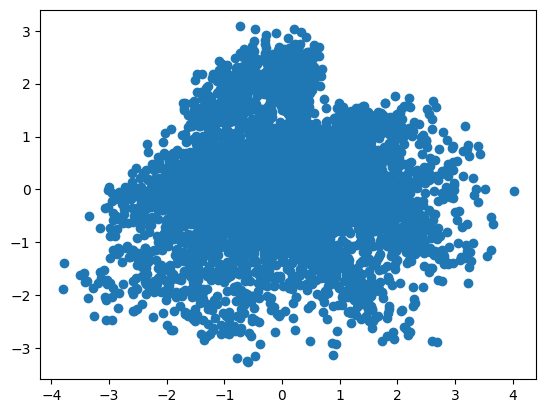

In [26]:
h = encoder.predict(x_test[:6000], batch_size=batch_size, verbose=0)
plt.scatter(h[:, 0], h[:, 1])
plt.show()

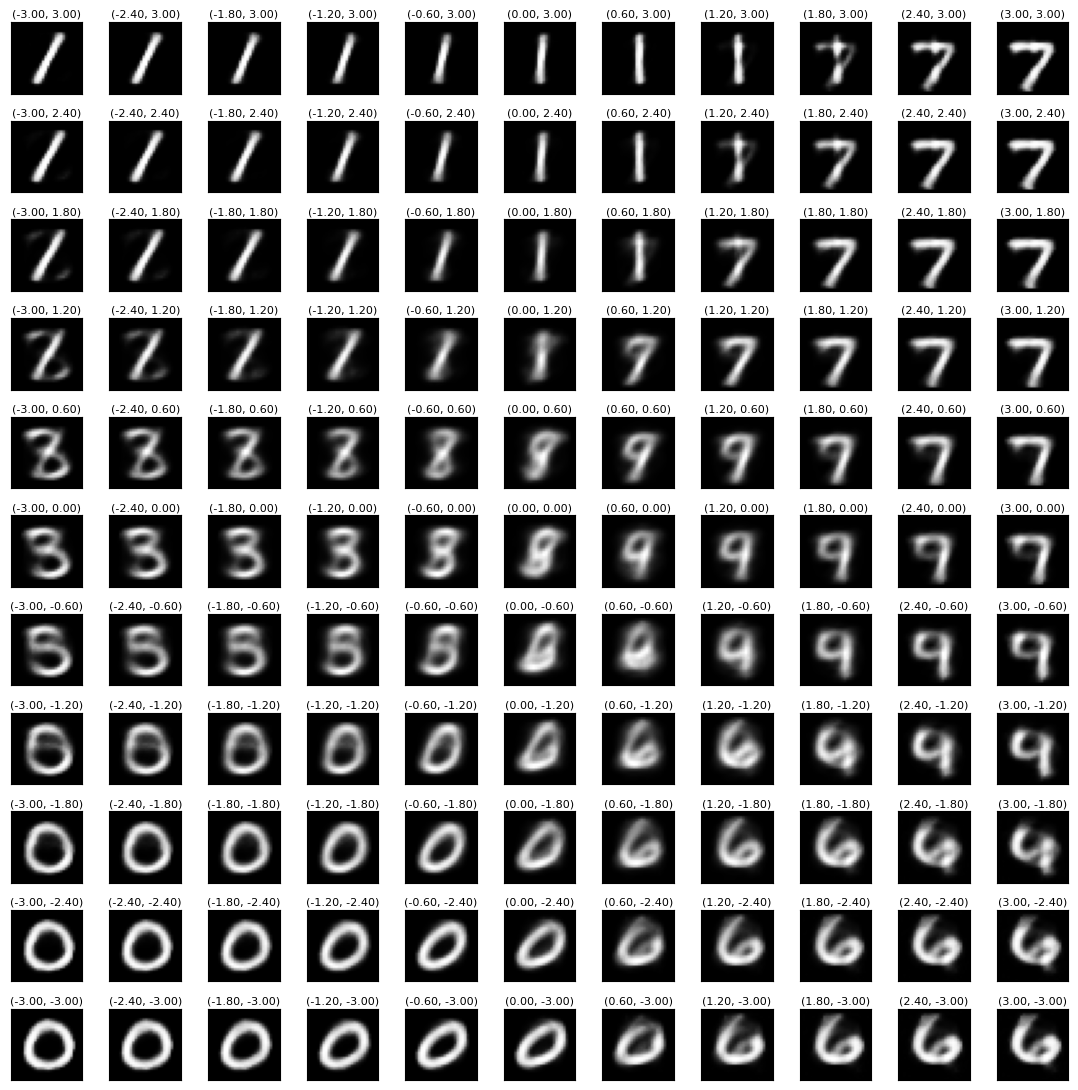

In [27]:
n = 5
total = 2*n+1

plt.figure(figsize=(total, total))

num = 1
for j in range(n, -n-1, -1):
    for i in range(-n, n+1):
        ax = plt.subplot(total, total, num)
        num += 1
        img = decoder.predict(np.expand_dims([3*i/n, 3*j/n], axis=0), verbose=0)
        plt.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'({3*i/n:.2f}, {3*j/n:.2f})', fontsize=8, pad=3)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

**How to improve?**
- CNN
- Increasing the hidden layer (here h size = 2)

## Projects

- [**Conditional VAE (CVAE)**](https://github.com/timbmg/VAE-CVAE-MNIST) - вариационные автоэнкодеры, которые используют дополнительные условные переменные для генерации данных
- [**Beta-VAE**](https://github.com/1Konny/Beta-VAE) - модификация VAE с дополнительным гиперпараметром для баланса между качеством реконструкции и качеством латентного пространства
- [**Disentangled VAE (β-VAE)**](https://github.com/YannDubs/disentangling-vae) - разработан для более эффективного обучения раздельных представлений в латентном пространстве

# Links

- https://www.youtube.com/watch?v=6qVfC7P9dEc
- https://towardsdatascience.com/difference-between-autoencoder-ae-and-variational-autoencoder-vae-ed7be1c038f2
- https://www.assemblyai.com/blog/introduction-to-variational-autoencoders-using-keras/
- https://www.youtube.com/watch?v=iLoCVz3RJTc&list=PLA0M1Bcd0w8yv0XGiF1wjerjSZVSrYbjh&index=29

# END